In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [28]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re

In [29]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [14]:
bright_factor = 0
best_n_runs = 30
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": False, "config.normtype": "ln_false",
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": False, "config.normtype": "ln_true",
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_only"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.task_opt_inhib": None, "config.use_sep_bias_gain_lrs": False }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_only_gain_bias"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 1 }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_frozen"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.task_opt_inhib": None, "config.use_sep_bias_gain_lrs": False, 
                                                                    "config.lambda_homeo": 0 }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_frozen_LN"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": "ln_true",
                                                                    "config.use_testset": True, "config.task_opt_inhib": None, "config.use_sep_bias_gain_lrs": False, 
                                                                    "config.lambda_homeo": 0 }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_EI"] = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": False }, order="-summary_metrics.test_acc")[:best_n_runs]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


Text(0, 0.5, 'Learning Rate')

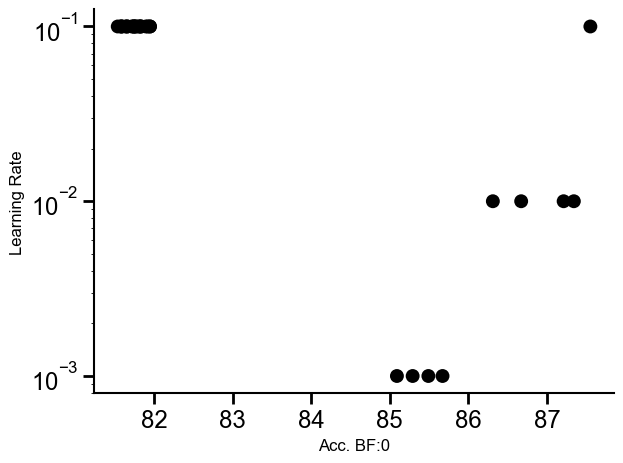

In [16]:
fig, ax = plt.subplots()
for idx, run in enumerate(runs_dict["runs_vanilla_dann"]):
    ax.scatter(run.summary['test_acc'], run.config['lr'],  alpha=1, edgecolors='none', color='black')

ax.set_yscale('log')
# ax.legend(fontsize="10", loc ="best")
ax.set_xlabel(f"Acc. BF:{bright_factor}")
ax.set_ylabel("Learning Rate")

Text(0, 0.5, 'Momentum')

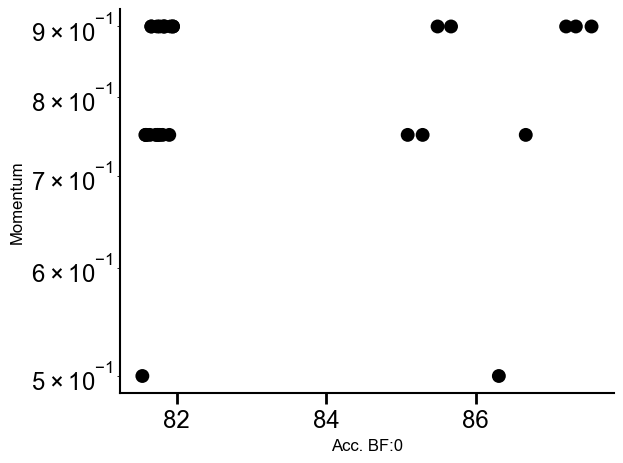

In [18]:
fig, ax = plt.subplots()
for idx, run in enumerate(runs_dict["runs_vanilla_dann"]):
    ax.scatter(run.summary['test_acc'], run.config['momentum'],  alpha=1, edgecolors='none', color='black')

ax.set_yscale('log')
# ax.legend(fontsize="10", loc ="best")
ax.set_xlabel(f"Acc. BF:{bright_factor}")
ax.set_ylabel("Momentum")

Text(0, 0.5, 'Inhibitory Momentum')

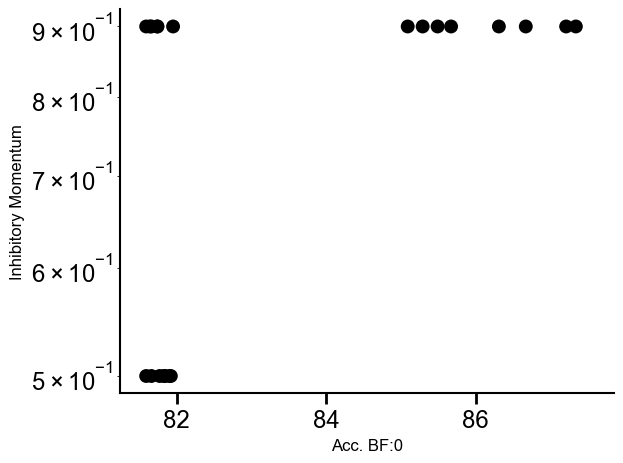

In [21]:
fig, ax = plt.subplots()
for idx, run in enumerate(runs_dict["runs_vanilla_dann"]):
    ax.scatter(run.summary['test_acc'], run.config['inhib_momentum'],  alpha=1, edgecolors='none', color='black')

ax.set_yscale('log')
# ax.legend(fontsize="10", loc ="best")
ax.set_xlabel(f"Acc. BF:{bright_factor}")
ax.set_ylabel("Inhibitory Momentum")

Text(0, 0.5, 'LR')

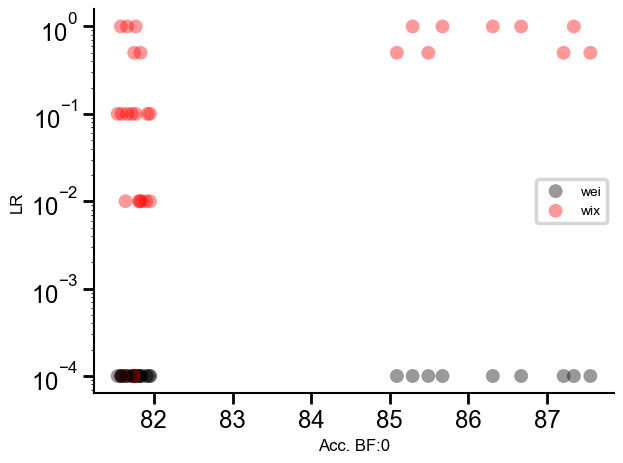

In [33]:
fig, ax = plt.subplots()
for idx, run in enumerate(runs_dict["runs_vanilla_dann"]):
    ns_string = run.config['inhib_lrs']
        # Use regular expressions to extract the key-value pairs
    matches = re.findall(r'(\w+)=([\d.]+)', ns_string)

    # Convert the matches into a dictionary
    ns_dict = {key: float(value) for key, value in matches}

    # Access the values
    wei = ns_dict.get('wei')
    wix = ns_dict.get('wix')
    ax.scatter(run.summary['test_acc'], wei,  alpha=0.4, edgecolors='none', color='black', label="wei" if idx==0 else None)
    ax.scatter(run.summary['test_acc'], wix,  alpha=0.4, edgecolors='none', color='red', label="wix" if idx==0 else None)

ax.set_yscale('log')
ax.legend(fontsize="10", loc ="best")
ax.set_xlabel(f"Acc. BF:{bright_factor}")
ax.set_ylabel("LR")